# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [5]:
# as convereted is a series of 0/1, mean() gives the proportions
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
# checking how many of each page type exist
df.landing_page.value_counts()

old_page    147239
new_page    147239
Name: landing_page, dtype: int64

In [7]:
df.query('group == "treatment" and landing_page != "new_page"').shape[0] + \
df.query('group == "control" and landing_page != "old_page"').shape[0]

3893

- The question was a bit misleading, but it seems what you wanted was the total of where group is `treatment` and landing_page is not `new_page` added together with total where group is `control` and landing_page is not `old_page`

**f.** Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


- No missing values

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  

In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2.
# using a mask for the complex boolean operation
mask = ((df['group'] == 'treatment') & (df['landing_page'] == 'old_page')) | ((df['group'] == 'control') & (df['landing_page'] == 'new_page'))
df[mask].shape[0]

3893

In [10]:
# using the inverse of the mask gives us the data we are after
df2 = df[~mask]

In [11]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  

**a.** How many unique **user_id**s are in **df2**?

In [12]:
df2.user_id.nunique()

290584

In [13]:
df2.shape[0]

290585

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [14]:
# lambda expression allows us to do a groupby > having count > 1 clause similar to what we'd do in a SQL query
df2.groupby(['user_id']).filter(lambda x: len(x) > 1)

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**c.** Display the rows for the duplicate **user_id**? 

In [15]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [16]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop_duplicates(subset=['user_id', 'group', 'landing_page', 'converted'], inplace=True)

# Check again if the row with a duplicate user_id is deleted or not
df2[df2.user_id == 773192]

C:\Users\doron\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


- We checked for duplicates across `user_id`, `group`, `landing_page`, `converted` but excluded `timestamp`, in order to correctly find the duplicate

### ToDo 1.4  

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>


In [17]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [18]:
p_pop = df2.converted.mean()
p_pop

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
p_control = df2[df2['group'] == 'control'].converted.mean()
p_control

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [20]:
p_treatment = df2[df2['group'] == 'treatment'].converted.mean()
p_treatment

0.11880806551510564

In [21]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_control - p_treatment
obs_diff

0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [22]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [23]:
df2[df2['landing_page'] == 'new_page'].shape[0]/df2.shape[0]

0.5000619442226688

- 50% of users saw old and new page each, which is what we'd be hoping for

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

> While there is a small difference between the control and treatment group, with the control group having slightly more conversations, its not clear whether this is a statistically significant difference, i.e. its not clear whether this difference is due to chance. To resolve this, a null and alternative hypothesis should be formulated and we should check against the null distriution to gauge how likely it is that sample statistics we obtain could have come from the null distribution. Based on current data as it stands, there appears to be no practical difference in the new and old web pages.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.


**$H_0$**:  **$p_{old}$** >= **$p_{new}$**<br>
**$H_1$**:  **$p_{old}$** < **$p_{new}$**
    

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [24]:
p_new = p_pop
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [25]:
p_old = p_pop
p_old

0.11959708724499628

- It was a stated assumption above that $p_{new}$ = $p_{old}$ = $p_{population}$

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [26]:
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [27]:
n_old = df2.query('group == "control"').shape[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>


In [28]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice(2, size=n_new, p=[1-p_new, p_new])
new_page_converted

array([0, 0, 0, ..., 1, 1, 0])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [29]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice(2, size=n_old, p=[1-p_old, p_old])
old_page_converted

array([1, 0, 0, ..., 0, 0, 0])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [30]:
new_page_converted.mean() - old_page_converted.mean()

-0.001130858068190313


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [31]:
# Sampling distribution
p_diffs = []
new_page_binomial = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_binomial = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_binomial - old_page_binomial

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>
Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

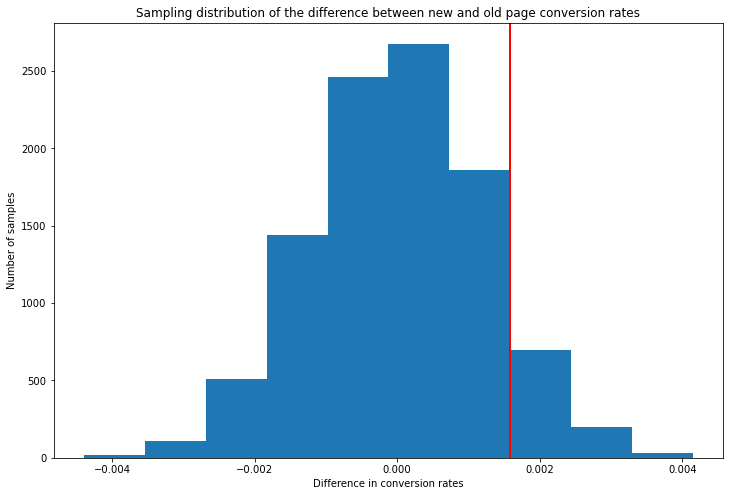

In [32]:
plt.figure(figsize=(12,8))
plt.hist(p_diffs)
plt.axvline(obs_diff,color='r', linewidth=2)
plt.xlabel('Difference in conversion rates')
plt.ylabel('Number of samples')
plt.title('Sampling distribution of the difference between new and old page conversion rates');

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [33]:
(p_diffs > obs_diff).mean()

0.0937

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

> We have calculated our p-value as 0.0946. Given that our threshold for type-1 errors is 0.05 and 0.0946 > 0.05, we do not have enough evidence to reject the null hypothesis that the new page and old page deliver the same conversion rate. This can also be confirmed from the visual above, i.e. the population conversion rate falls within the normal distribution generated from our null hypothesis and thus we cannot reject this null hypothesis.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [34]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page"').converted.sum()

# number of conversions with the new_page
convert_new = df2.query('landing_page == "new_page"').converted.sum()

# number of individuals who were shown the old_page
n_old = df2.query('landing_page == "old_page"').shape[0]

# number of individuals who received new_page
n_new = df2.query('landing_page == "new_page"').shape[0]

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. 
>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 


In other words, we determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. A "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.



Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org


In [35]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(count=[convert_old, convert_new], nobs=[n_old, n_new], alternative='larger')
print(z_score, p_value)

1.3109241984234394 0.09494168724097551


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

> The p-value here is 0.095 > 0.05 threshold, which suggests that we cannot reject the null hypothesis. This p-value agrees with what we calculated earlier. The z-score can be interpreted as the number of standard deviations away from the mean our sample is, i.e. with only 1.3 standard deviations from the mean and 1.31 < $Z_{0.05}$ of 1.645, we cannot reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

> Logistics regression

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [36]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [37]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

C:\Users\doron\AppData\Local\Temp/ipykernel_10840/37183689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['intercept'] = 1
C:\Users\doron\AppData\Local\Temp/ipykernel_10840/37183689.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [38]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 13 Oct 2021   Pseudo R-squ.:               8.077e-06
Time:                        08:06:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Hints**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


>In Part 2, we had a one-sided hypothesis, such that $H_1$: $p_{new} > p_{old}$. In Part 3, using Statsmodels Logit() function, we are using a two-sided hypothesis test, such that $H_1$: $p_{new} != p_{old}$

To prove this, let's see what happens if we change our hypothesis in part 2 to a two-sided test.

In [40]:
# probability of a statistic higher than observed
prob_more_extreme_high = (np.array(p_diffs) > obs_diff).mean()
    
# probability a statistic is more extreme lower
prob_more_extreme_low = (np.array(p_diffs) - (obs_diff - np.array(p_diffs)) > np.array(p_diffs)).mean()

pval = prob_more_extreme_low + prob_more_extreme_high
pval

0.1874

> We've obtained 0.1892 which almost exactly matches the p-value we got from the logistic regression, allowing us to conclude that the difference in results is indeed due to Part 2 being a one-sided test, while part 3 is a two-sided test.

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> In the real-world, there are almost always many reasons why something occurs, or something works or doesnt. We should aim to try determine as much as we can regarding why people convert or do not convert, as in our example. Its quite likely that other factors are at play, so provided we have data to investigate those factors, we should try out best to incorporate them into the analysis. Having said that, doing so does increase the risk of multicollinearity in our model and we'll need to account for more complex (possibly non-linear) relationships.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Hint:** Use `pandas.get_dummies()` to create dummy variables. **You will utilize two columns for the three dummy variables.** 

 Provide the statistical output as well as a written response to answer this question.

In [41]:
# Read the countries.csv
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [42]:
# Join with the df2 dataframe
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [43]:
df_merged = df2.set_index('user_id').join(countries.set_index('user_id'), on='user_id', how='left')
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [44]:
df_merged.country.isna().sum()

0

In [45]:
# Create the necessary dummy variables
df_merged[['UK', 'US']] = pd.get_dummies(df_merged['country'])[['UK', 'US']]
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US
user_id,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1


In [46]:
# Fit your model, and summarize the results
log_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 13 Oct 2021   Pseudo R-squ.:               2.323e-05
Time:                        08:06:52   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

> Based on the above, we don't see statistically significant results for either the page or country, as contributing to the conversion of the new page. All of the variables have a p-value > 0.05 threshold. As such, we fail to reject the null hypothesis on the regression model, using the two-sided test provided by the model. Practically speaking, this makes sense - since we already have seen that there is little difference between the old and new pages in terms of overall conversion, the country of origin of the user would then have even less of an impact. 

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results.

In [47]:
# Lets now model the interaction between page and country and build a new model
df_merged["ab_UK"] = df_merged["ab_page"] * df_merged["UK"]
df_merged["ab_US"] = df_merged["ab_page"] * df_merged["US"]
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,ab_UK,ab_US
user_id,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1,0,0


In [48]:
log_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US', 'ab_UK', 'ab_US']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 13 Oct 2021   Pseudo R-squ.:               3.482e-05
Time:                        08:06:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
ab_UK          0.0783      0.057      1.378      0.168      -0.033       0.190
ab_US          0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

> When including the interaction between page and country, we see that the p-value for the interaction variables is > 0. 05 and thus, we cannot use them as evidence to reject the null hypothesis.

### Modelling additional relationships

Let's now see if we can extract further insight from the timestamp variable. We'll break this apart into day, week, month and year

In [49]:
df_merged.timestamp.min(), df_merged.timestamp.max()

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

I'd like to create a few additional variables:
- Bin the time of day into various time periods - `Late Night`, `Early Morning`,`Morning`,`Noon`,`Eve`,`Night`

In [50]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 851104 to 715931
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   timestamp     290584 non-null  object
 1   group         290584 non-null  object
 2   landing_page  290584 non-null  object
 3   converted     290584 non-null  int64 
 4   intercept     290584 non-null  int64 
 5   ab_page       290584 non-null  uint8 
 6   country       290584 non-null  object
 7   UK            290584 non-null  uint8 
 8   US            290584 non-null  uint8 
 9   ab_UK         290584 non-null  uint8 
 10  ab_US         290584 non-null  uint8 
dtypes: int64(2), object(4), uint8(5)
memory usage: 16.9+ MB


- timestamp needs to be converted to datetime format in order to extract the hour from it using built-in functions.

In [51]:
# binning the timestamp into morning, afternoon or evening
# ref: https://stackoverflow.com/questions/55571311/get-part-of-day-morning-afternoon-evening-night-in-python-dataframe
b = [0,4,8,12,16,20,24]
l = ['late_night', 'early_morning','morning','noon','eve','night']
df_merged['day_period'] = pd.cut(pd.to_datetime(df_merged['timestamp']).dt.hour, bins=b, labels=l, include_lowest=True)
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,ab_UK,ab_US,day_period
user_id,,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1,0,0,night
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1,0,0,early_morning
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,0,1,noon
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,0,1,eve
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1,0,0,late_night


In [52]:
df_merged.day_period.value_counts()

late_night       60361
early_morning    48592
eve              48529
noon             48419
morning          48363
night            36320
Name: day_period, dtype: int64

Lets create dummy variables for the various `day_periods`. I'll leave out `Night` to ensure the matrix is full rank.

In [53]:
cols = sorted(pd.get_dummies(df_merged['day_period']).columns)
cols.remove('night')
cols

['early_morning', 'eve', 'late_night', 'morning', 'noon']

In [54]:
pd.get_dummies(df_merged['day_period'])[cols]

,early_morning,eve,late_night,morning,noon
user_id,,,,,
851104,0,0,0,0,0
804228,1,0,0,0,0
661590,0,0,0,0,1
853541,0,1,0,0,0
864975,0,0,1,0,0
...,...,...,...,...,...
751197,0,0,0,0,0
945152,0,0,1,0,0
734608,0,0,0,1,0


In [55]:
cols

['early_morning', 'eve', 'late_night', 'morning', 'noon']

In [56]:
df_merged[['early_morning', 'eve', 'late_night', 'morning', 'noon']] = pd.get_dummies(df_merged['day_period'])[cols]
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,ab_UK,ab_US,day_period,early_morning,eve,late_night,morning,noon
user_id,,,,,,,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1,0,0,night,0,0,0,0,0
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1,0,0,early_morning,1,0,0,0,0
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,0,1,noon,0,0,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,0,1,eve,0,1,0,0,0
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1,0,0,late_night,0,0,1,0,0


In [57]:
log_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'UK', 'US', 'early_morning', 'eve', 'late_night', 'morning', 'noon']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366084
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290575
Method:                           MLE   Df Model:                            8
Date:                Wed, 13 Oct 2021   Pseudo R-squ.:               0.0001012
Time:                        08:06:56   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                  0.005854
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        -2.0118      0.031    -65.901      0.000      -2.072      -1.952
ab_page          -0.0149      0.011     -1.304      0.192      -0.037       0.008
UK                0.0507      0.028      1.787      0.074      -0.005       0.106
US                0.0408      0.027      1.518      0.129      -0.012       0.093
early_morning    -0.0186      0.021     -0.873      0.383      -0.060       0.023
eve              -0.0043      0.021     -0.204      0.838      -0.046       0.037
late_night       -0.0598      0.021     -2.919      0.004      -0.100      -0.020
morning           0.0078      0.021      0.367      0.713      -0.034       0.049
noon             -0.0212      0.021     -0.995      0.320      -0.063       0.021
=================================================================================
"""

It appears that `late_night` does give us a statistically significant result. Let's exponentiate 

In [58]:
np.exp(-0.0598)

0.941952905327512

In [59]:
1/np.exp(-0.0598)

1.0616242004713659

> For every 1 unit decrease in late night, conversion is 1.06 times as likely, holding all other variables constant. This however, does not have any practical significance given how small this effect is, even though its statistically significant. 

## Conclusion

In the analysis we used different mechanisms to test whether a new version of a landing page performed better than an existing page. 
<br><br>
Our findings are as follows:
-  A small difference between the control and treatment group was observed, with the control group having slight more conversions, however hypothesis testing and/or regression models were required to determine if this difference was statistically significant and not due to chance.
- Using a one-sided Hypothesis test with H0 being that the conversion rate of old page >= new page, we have calculated our p-value as 0.0946. Given that our threshold for type-1 errors is 0.05 and 0.0946 > 0.05, we do not have enough evidence to reject the null hypothesis that the new page and old page deliver the same conversion rate. 
- Using a Z-score, we confirmed the same, obtaining a p-value of 0.095 > 0.05 threshold, which suggests that we cannot reject the null hypothesis. 
- When using a regression model to investigate page, country and interaction variables between page and country, all of the variables have a p-value > 0.05 threshold. As such, we fail to reject the null hypothesis on the regression model, using the two-sided test provided by the model. 
- Finally, we added variable to bucket the hour of day and we noted a statistically significant result for late night bucket (midnight to 4am), however it has no practical significance as the effect is too small. 
<br><br>
- __Overall result: The new page has not improved conversion rate on the website. It is suggested that an alternative design should be tried, rather than giving this current design more time in the trial.__